In [1]:
import os
import sys
import librosa
import seaborn as sn
sys.path.append(os.path.abspath(os.path.join('../')))
from scripts.audio_loader import AudioLoader
from scripts.audio_manuplator import AudioManipulator
import scripts.visualize as vis
from scripts.results_pickler import ResultPickler
# import audio_manuplator as am
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


## Load Audio files

In [2]:
al_train = AudioLoader(directory='../data/train')
# al_test = AudioLoader(directory="../data/test",tts_file=r'/trsTest.txt')


AudioExplorer:INFO->Successfully Created AudioExplorer Class
AudioExplorer:INFO->Successfully Loaded Audio and TTS files
AudioPreprocessor:INFO->Successfully Inherited AudioExplorer Class
AudioPreprocessor:INFO->Successfully Inherited AudioExplorer Class


In [3]:
df_train_audio_data = al_train.get_audio_info_with_data()
# df_test_audio_data = al_test.get_audio_info_with_data()
# rp = ResultPickler()
# rp.load_data("../models/LoadedAudioInfo.pkl")
# data_dict = rp.get_data()
# # data_dict.keys()
# df_train_audio_data = data_dict['TrainAudioInfoWithoutTTS']
df_train_audio_data


,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_10577_tr30138,6.223,Mono,16000,"[-0.12817383, -0.12756348, -0.12817383, -0.128...",True
1,tr_10617_tr04131,3.344,Mono,16000,"[-0.1159668, -0.11657715, -0.1171875, -0.11657...",True
2,tr_10399_tr23101,2.322,Mono,16000,"[-0.12695312, -0.12756348, -0.12695312, -0.127...",True
3,tr_10379_tr100101,3.065,Mono,16000,"[-0.13061523, -0.13000488, -0.13000488, -0.131...",True
4,tr_10171_tr099013,5.294,Mono,16000,"[-0.12634277, -0.12512207, -0.12573242, -0.126...",True
...,...,...,...,...,...,...
994,tr_1016_tr11017,8.288,Mono,16000,"[-0.01965332, -0.01965332, -0.01977539, -0.019...",True
995,tr_10054_tr098016,3.344,Mono,16000,"[-0.13000488, -0.12939453, -0.12817383, -0.127...",True
996,tr_10_tr01010,7.523,Mono,16000,"[-0.0057678223, -0.006011963, -0.0059814453, -...",True
997,tr_10370_tr100092,2.601,Mono,16000,"[-0.123291016, -0.12390137, -0.12451172, -0.12...",True


In [4]:

# instantiate audio manuplator class
am_train = AudioManipulator(df_train_audio_data)


AudioPreprocessor:ERROR->successfully Initialized AudioPreprocessor class!
NoneType: None
AudioPreprocessor:ERROR->successfully Initialized AudioPreprocessor class!
NoneType: None


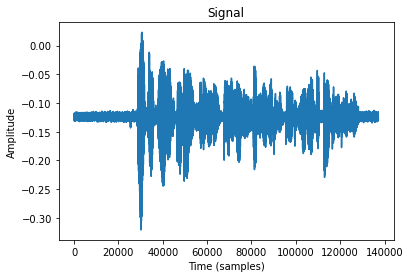

In [5]:
# Plot Time Series data of 
vis.plot_series(df_train_audio_data.loc[0,"TimeSeriesData"])


## Preprocessing the audio Data
- ### change the duration to the same size
- ### convert channels to stereo by duplicating the other channel
- ### standardize the sampling rate to the same one
- ### Data Augmentation
- ### Extract Features



### Convert Channels to Stereo by duplicating the other channel


In [6]:
am_train.convert_stereo_audio()
am_train.get_audio_info()

,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_10577_tr30138,6.223,Stereo,16000,"[[-0.12817383, -0.12756348, -0.12817383, -0.12...",True
1,tr_10617_tr04131,3.344,Stereo,16000,"[[-0.1159668, -0.11657715, -0.1171875, -0.1165...",True
2,tr_10399_tr23101,2.322,Stereo,16000,"[[-0.12695312, -0.12756348, -0.12695312, -0.12...",True
3,tr_10379_tr100101,3.065,Stereo,16000,"[[-0.13061523, -0.13000488, -0.13000488, -0.13...",True
4,tr_10171_tr099013,5.294,Stereo,16000,"[[-0.12634277, -0.12512207, -0.12573242, -0.12...",True
...,...,...,...,...,...,...
994,tr_1016_tr11017,8.288,Stereo,16000,"[[-0.01965332, -0.01965332, -0.01977539, -0.01...",True
995,tr_10054_tr098016,3.344,Stereo,16000,"[[-0.13000488, -0.12939453, -0.12817383, -0.12...",True
996,tr_10_tr01010,7.523,Stereo,16000,"[[-0.0057678223, -0.006011963, -0.0059814453, ...",True
997,tr_10370_tr100092,2.601,Stereo,16000,"[[-0.123291016, -0.12390137, -0.12451172, -0.1...",True


In [7]:
# am_train.get_audio_info().head().loc[0,"TimeSeriesData"].shape
num_rows, y_len = am_train.get_audio_info().loc[0,"TimeSeriesData"].shape
num_rows,y_len

(2, 137216)

### Change the duration to the same size
From Our Data Exploration, we found that most frequent audio files has a duration between 2 to 6. And to reduce the bias, we will pad all the audio to make it equal in length with the maximum.

In [8]:
am_train.resize_audio()


211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
2

211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0
211024.0


In [9]:
am_train.get_audio_info()

,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_10577_tr30138,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
1,tr_10617_tr04131,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
2,tr_10399_tr23101,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
3,tr_10379_tr100101,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
4,tr_10171_tr099013,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
...,...,...,...,...,...,...
994,tr_1016_tr11017,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
995,tr_10054_tr098016,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
996,tr_10_tr01010,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
997,tr_10370_tr100092,9.57,Stereo,16000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True


In [10]:
am_train.get_audio_info().loc[0,"TimeSeriesData"].shape

(2, 211024)

### Standardize Sampling Rate

In [11]:
# count sampling rate frequencies
pd.DataFrame({"count": df_train_audio_data.groupby("SamplingRate")["SamplingRate"].count()})


,count
SamplingRate,
16000,999


In [12]:
am_train.resample_audio()

In [13]:
am_train.get_audio_info()

,Name,Duration,Channels,SamplingRate,TimeSeriesData,HasTTS
0,tr_10577_tr30138,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
1,tr_10617_tr04131,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
2,tr_10399_tr23101,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
3,tr_10379_tr100101,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
4,tr_10171_tr099013,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
...,...,...,...,...,...,...
994,tr_1016_tr11017,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
995,tr_10054_tr098016,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
996,tr_10_tr01010,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
997,tr_10370_tr100092,9.57,Stereo,22500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True


### Our SamplingRate is the same all around our data but we have resampled it to 44100. Now we have our processed data, we will save the preprocessed files to a folder in a .wav format. 

 

In [14]:
am_train.write_wave_files("../data/train/wav/")

## Augmentation

## Feature Extraction
### We can now extract features but first we convert back to mono since the librosa library expects a monochannel audio.

In [24]:

# features = am_train.extract_features()

/home/dibora/AMH-STT/STT/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=132
  n_fft, y.shape[-1]


In [25]:
# features.head()

,Name,Melspectogram,Melspectogram_db
0,tr_1003_tr11004,"[[2.7900546], [0.041047245], [0.0005915265], [...","[[0.0], [-18.323288], [-36.736385], [-46.55433..."
1,tr_10577_tr30138,"[[82.89139], [1.2032433], [0.15116173], [0.045...","[[-1.9073486e-06], [-18.381561], [-27.390676],..."
2,tr_10617_tr04131,"[[81.84967], [1.2774433], [0.1626715], [0.1271...","[[0.0], [-18.066753], [-27.017056], [-28.08648..."
3,tr_10399_tr23101,"[[85.895645], [1.2551126], [0.038612414], [0.0...","[[0.0], [-18.352884], [-33.472443], [-44.09732..."
4,tr_10379_tr100101,"[[86.75957], [1.2598524], [0.12583095], [0.034...","[[1.9073486e-06], [-18.379976], [-28.385298], ..."


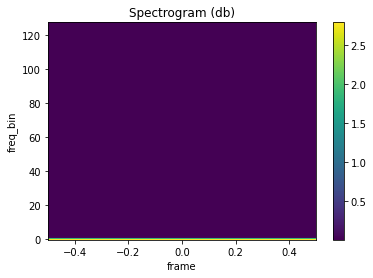

In [26]:
# vis.plot_spectrogram(features.loc[0,'Melspectogram'])

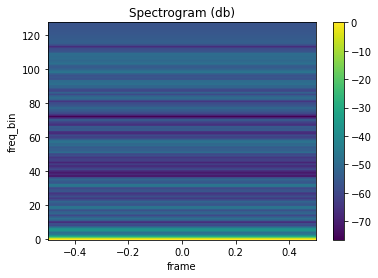

In [27]:
# vis.plot_spectrogram(features.loc[0,'Melspectogram_db'])